In [7]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD

import matplotlib.pyplot as plt
import preprocess.preprocess as preprocess
from utils import metrics
import time
import pandas as pd
import ants
import numpy as np
from tqdm import tqdm
import json

In [2]:
# Dataset
data_path = Path('/home/kaouther/Documents/GitHub/mira_final_project/data')

data = DirLabCOPD(
    data_path=data_path,
    cases=['all'],
    partitions=['train'],
    return_lm_mask=False,
    normalization_cfg=None,
    return_body_masks=False,
    return_lung_masks=True
)

In [3]:
len(data)

4

## Demonstration

In [4]:
sample = data[3]
fixed = ants.image_read(sample['e_img_path']) 
spacing = fixed.spacing
origin = fixed.origin
direction = fixed.direction

In [5]:
fixed = ants.from_numpy(sample['e_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
moving = ants.from_numpy(sample['i_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
# mask_fix = ants.from_numpy(sample['e_lung_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
# mask_mov = ants.from_numpy(sample['i_lung_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
# lm_mask = ants.from_numpy(sample['e_lm_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

In [6]:
fixed = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
fixed = ants.iMath_truncate_intensity( fixed, 0.05, 0.95)
moving = ants.iMath(moving, 'Normalize', 0.0, 1.0)
moving = ants.iMath_truncate_intensity(moving, 0.05, 0.95 )

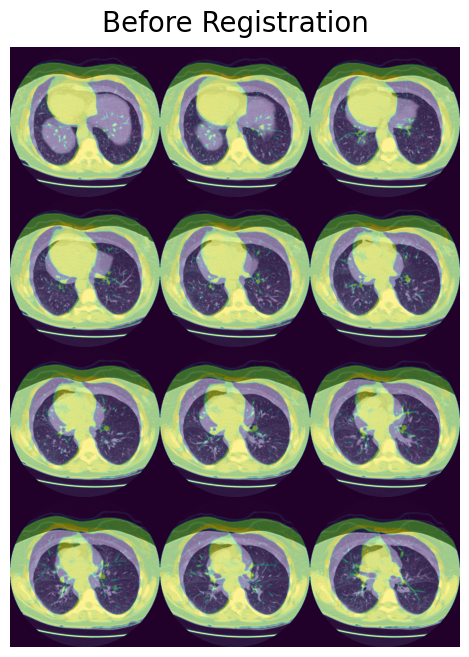

In [7]:
fixed.plot(overlay=moving, title='Before Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [10]:
mytx = ants.registration(fixed=fixed, 
                         moving=moving, 
                         #outprefix='/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/',
                         #mask=mask_fix,
                         total_sigma= 0.25,
                         aff_iterations=(100, 100, 100, 50, 0),
                         aff_shrink_factors=(8, 6, 4, 2, 1),
                         aff_smoothing_sigmas=(10, 1, 0, 0, 0),
                         flow_sigma= 10,
                         type_of_transform="SyN",
                         syn_sampling=16,
                         reg_iterations=(100, 100, 50, 0, 0),
                         syn_metric='MI',
                         verbose=True,
                         )

antsRegistration -d 3 -r [0x55ef38255020,0x55ef36325ba0,1] -m mattes[0x55ef38255020,0x55ef36325ba0,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m MI[0x55ef38255020,0x55ef36325ba0,1,16] -t SyN[0.200000,10.000000,0.250000] -c [100x100x50x0x0,1e-7,8] -s 4x3x2x1x0 -f 16x8x4x2x1 -u 1 -z 1 -o [/tmp/tmpe7o6a1qy,0x55ef362ff310,0x55ef37fd7790] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x55ef38255020 and moving image: 0x55ef36325ba0 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
    Registration stage 1
      No fixed mask
      No moving mask
  number of levels = 4
  number of levels = 5
  fixed image: 0x55ef38255020
  moving image: 0x55ef36325ba0
  fixed image: 0x55ef38255020
  moving image: 0x5

In [11]:
registered = mytx['warpedmovout']

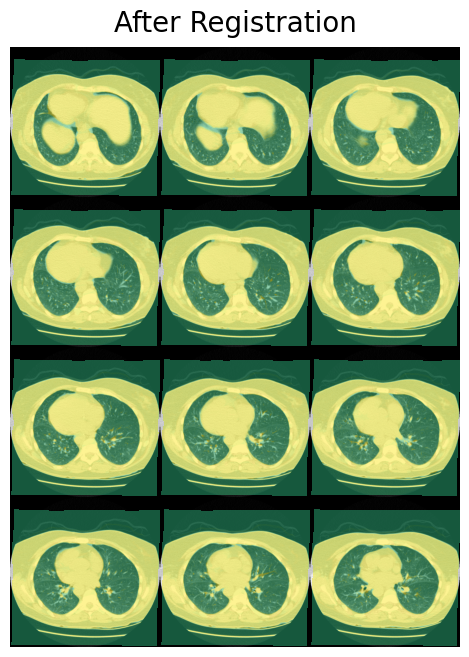

In [12]:
fixed.plot(overlay=registered, title='After Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

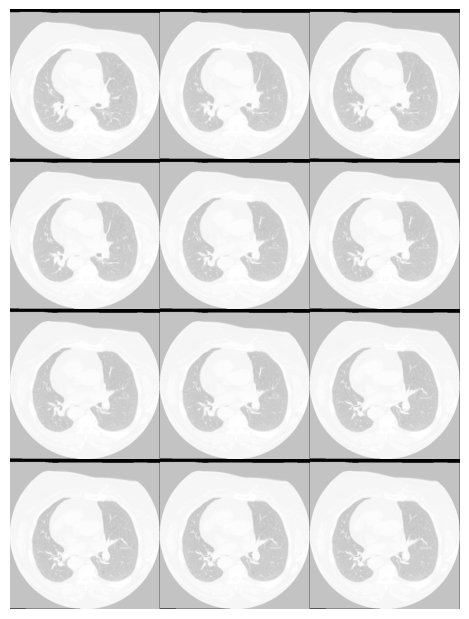

In [69]:
registered.plot(axis=2)

In [11]:
mytx['invtransforms']

['/tmp/tmp0ae_uist0GenericAffine.mat', '/tmp/tmp0ae_uist1InverseWarp.nii.gz']

In [13]:
case_path = Path(sample['i_img_path']).parent
lm_filepath_fixed = case_path / f"{sample['case']}_eBHCT_lm.csv"
lm_filepath_moving = case_path / f"{sample['case']}_iBHCT_lm.csv"
landmarks_fixed_df = pd.read_csv(lm_filepath_fixed)
landmarks_moving_df = pd.read_csv(lm_filepath_moving)

landmarks_fixed_df = landmarks_fixed_df[['x', 'y','z']]
landmarks_moving_df = landmarks_moving_df[['x', 'y','z']]

landmarks_fixed = landmarks_fixed_df.to_numpy(dtype=np.float32)

landmarks_result = ants.apply_transforms_to_points(3, landmarks_moving_df, mytx['invtransforms'], whichtoinvert=[True, False]).to_numpy(dtype=np.float32)
tre = metrics.target_registration_error(landmarks_result, landmarks_fixed, [1.0, 1.0, 1.0])

print(f'TRE: {tre[0]}, {tre[1]}')
print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_std"]}')

TRE: 11.09, 4.23
Initial displacement GT: 30.9, 13.49


## Experiments

In [15]:
def register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask = False, save_registered = False):

    res_dir = Path('/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms')
    res_path = res_dir/ exp_name / sample['case']
    res_path.mkdir(exist_ok=True, parents=True)
    
    fixed = ants.image_read(sample['e_img_path']) 
    spacing = fixed.spacing
    origin = fixed.origin
    direction = fixed.direction

    fixed = ants.from_numpy(sample['e_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
    moving = ants.from_numpy(sample['i_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

    if use_mask:
        mask = ants.from_numpy(sample['e_lung_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
    else:
        mask = None

    fixed = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
    fixed = ants.iMath_truncate_intensity( fixed, 0.05, 0.95)
    moving = ants.iMath(moving, 'Normalize', 0.0, 1.0)
    moving = ants.iMath_truncate_intensity(moving, 0.05, 0.95)

    start = time.time()
    mytx =ants.registration(fixed=fixed, 
                            moving=moving,
                            outprefix=str(res_path),
                            type_of_transform=transform,
                            syn_sampling= sampling,
                            syn_metric=metric,
                            reg_iterations=iterations,
                            total_sigma=0.25,
                            flow_sigma=10,
                            mask=mask)
                                
                                
    reg_time = time.time() - start

    if save_registered:
        img_path = res_path / f"{sample['case']}_registered.nii.gz"
        ants.image_write(mytx['warpedmovout'], str(img_path))

    case_path = Path(sample['i_img_path']).parent
    lm_filepath_fixed = case_path / f"{sample['case']}_eBHCT_lm.csv"
    lm_filepath_moving = case_path / f"{sample['case']}_iBHCT_lm.csv"
    landmarks_fixed_df = pd.read_csv(lm_filepath_fixed)
    landmarks_moving_df = pd.read_csv(lm_filepath_moving)

    landmarks_fixed_df = landmarks_fixed_df[['x', 'y','z']]
    landmarks_moving_df = landmarks_moving_df[['x', 'y','z']]

    landmarks_fixed = landmarks_fixed_df.to_numpy(dtype=np.float32)

    landmarks_result = ants.apply_transforms_to_points(3, landmarks_moving_df, mytx['invtransforms'], whichtoinvert=[True, False]).to_numpy(dtype=np.float32)
    tre = metrics.target_registration_error(landmarks_result, landmarks_fixed, [1.0, 1.0, 1.0])

    return tre, reg_time

In [16]:
base_path = Path().resolve().parent

### Exp 01

In [16]:

results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_mse_nomask"

transform = "SyNOnly" 
metric = "meansquares"
iterations = (160, 80, 20, 1)
sampling = 32 
use_mask = False 
save_registered = False

In [17]:
results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

100%|██████████| 4/4 [23:01<00:00, 345.33s/it]


In [18]:
results_exp

{'copd1': {'mean_tre': 12.51, 'std_tre': 6.95, 'time': 345.604238986969},
 'copd2': {'mean_tre': 16.85, 'std_tre': 6.32, 'time': 233.39152812957764},
 'copd3': {'mean_tre': 6.76, 'std_tre': 3.46, 'time': 352.56587982177734},
 'copd4': {'mean_tre': 15.48, 'std_tre': 4.45, 'time': 431.14112067222595}}

In [19]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

 ### Exp 02

In [20]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_mi_nomask"

transform = "SyNOnly" 
metric = "MI"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = False 
save_registered = False

In [21]:
results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

100%|██████████| 4/4 [11:18<00:00, 169.55s/it]


In [22]:
results_exp

{'copd1': {'mean_tre': 8.43, 'std_tre': 5.76, 'time': 175.4749720096588},
 'copd2': {'mean_tre': 12.48, 'std_tre': 6.19, 'time': 142.5781328678131},
 'copd3': {'mean_tre': 5.46, 'std_tre': 3.64, 'time': 156.36799883842468},
 'copd4': {'mean_tre': 14.43, 'std_tre': 5.17, 'time': 184.9637486934662}}

### Exp 03

In [23]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_demons_nomask"

transform = "SyNOnly" 
metric = "demons"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }



100%|██████████| 4/4 [17:16<00:00, 259.15s/it]


In [24]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

In [25]:
results_exp

{'copd1': {'mean_tre': 16.44, 'std_tre': 8.24, 'time': 287.5064046382904},
 'copd2': {'mean_tre': 21.76, 'std_tre': 10.39, 'time': 200.0733950138092},
 'copd3': {'mean_tre': 15.82, 'std_tre': 9.02, 'time': 278.3817276954651},
 'copd4': {'mean_tre': 17.88, 'std_tre': 7.68, 'time': 252.12780666351318}}

### Exp 04

In [26]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_mi_mask"

transform = "SyNOnly" 
metric = "MI"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = True 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))


results_exp

100%|██████████| 4/4 [11:34<00:00, 173.53s/it]


{'copd1': {'mean_tre': 11.56, 'std_tre': 8.22, 'time': 220.21566653251648},
 'copd2': {'mean_tre': 10.24, 'std_tre': 6.0, 'time': 153.60014748573303},
 'copd3': {'mean_tre': 4.11, 'std_tre': 3.84, 'time': 141.1744303703308},
 'copd4': {'mean_tre': 21.95, 'std_tre': 7.1, 'time': 160.09635162353516}}

### Exp 05

In [29]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "syn_mi"

transform = "SyN" 
metric = "MI"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))


results_exp

100%|██████████| 4/4 [13:45<00:00, 206.50s/it]


{'copd1': {'mean_tre': 8.09, 'std_tre': 4.86, 'time': 208.0026514530182},
 'copd2': {'mean_tre': 14.48, 'std_tre': 6.56, 'time': 168.66385436058044},
 'copd3': {'mean_tre': 5.91, 'std_tre': 3.8, 'time': 212.61056995391846},
 'copd4': {'mean_tre': 13.45, 'std_tre': 4.15, 'time': 218.4245090484619}}

### Exp 06

In [30]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "elastic_syn_mi"

transform = "ElasticSyN"
metric = "MI"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))


results_exp

100%|██████████| 4/4 [15:05<00:00, 226.46s/it]


{'copd1': {'mean_tre': 8.09, 'std_tre': 4.95, 'time': 227.88413667678833},
 'copd2': {'mean_tre': 14.29, 'std_tre': 6.53, 'time': 187.3616955280304},
 'copd3': {'mean_tre': 5.94, 'std_tre': 3.82, 'time': 222.88166570663452},
 'copd4': {'mean_tre': 13.02, 'std_tre': 4.26, 'time': 248.80757975578308}}

### Exp 07

In [6]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "syn_mi_16_sampl"

transform = "SyN" 
metric = "MI"
iterations = (100, 100, 50, 0, 0)
sampling = 16 
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))


results_exp

100%|██████████| 4/4 [14:21<00:00, 215.47s/it]


{'copd1': {'mean_tre': 8.15, 'std_tre': 4.62, 'time': 281.4879062175751},
 'copd2': {'mean_tre': 13.67, 'std_tre': 6.47, 'time': 138.95506763458252},
 'copd3': {'mean_tre': 5.74, 'std_tre': 3.58, 'time': 195.87274312973022},
 'copd4': {'mean_tre': 10.62, 'std_tre': 4.14, 'time': 226.96183490753174}}

### Exp 08

In [48]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "syn_mi_8_sampl"

transform = "SyN" 
metric = "MI"
iterations = (100, 100, 50, 0, 0)
sampling = 8
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

100%|██████████| 4/4 [12:33<00:00, 188.37s/it]


In [49]:
results_exp

{'copd1': {'mean_tre': 8.7, 'std_tre': 4.62, 'time': 166.0295374393463},
 'copd2': {'mean_tre': 15.0, 'std_tre': 6.29, 'time': 128.35278725624084},
 'copd3': {'mean_tre': 5.56, 'std_tre': 3.21, 'time': 216.33605098724365},
 'copd4': {'mean_tre': 9.91, 'std_tre': 4.19, 'time': 223.71764755249023}}

### Exp 09

In [18]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "syn_GC"

transform = "SyN" 
metric = "GC"
iterations = (100, 100, 50, 0, 0)
sampling = 16
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

100%|██████████| 4/4 [16:09<00:00, 242.34s/it]


In [20]:
results_exp

{'copd1': {'mean_tre': 11.83, 'std_tre': 5.02, 'time': 235.9762613773346},
 'copd2': {'mean_tre': 19.62, 'std_tre': 6.14, 'time': 193.0841076374054},
 'copd3': {'mean_tre': 11.11, 'std_tre': 3.89, 'time': 258.3237783908844},
 'copd4': {'mean_tre': 24.78, 'std_tre': 5.67, 'time': 262.4206507205963}}

### Exp 10

In [17]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "syn_mi_more_it"

transform = "SyN" 
metric = "MI"
iterations = (100, 100, 50, 10, 0, 0)
sampling = 16
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

results_exp

100%|██████████| 4/4 [08:19<00:00, 124.79s/it]


{'copd1': {'mean_tre': 8.98, 'std_tre': 4.64, 'time': 128.14526414871216},
 'copd2': {'mean_tre': 14.96, 'std_tre': 6.95, 'time': 92.50809049606323},
 'copd3': {'mean_tre': 5.45, 'std_tre': 3.7, 'time': 116.55970191955566},
 'copd4': {'mean_tre': 9.46, 'std_tre': 4.92, 'time': 143.2901108264923}}

## Plots

In [8]:
base_path = Path().resolve().parent
results_path = base_path / 'experiments/ants/results.json'
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = []
for exp_name in results.keys():
    if results[exp_name] is None:
        row = [None, None, None, None, None]
    else:
        for case in results[exp_name].keys():
            columns = ['exp_name'] + list(results[exp_name][case].keys()) + ['case']
            row = [exp_name] + list(results[exp_name][case].values()) + [case]
            df.append(row)
df = pd.DataFrame(df, columns=columns)
df

,exp_name,mean_tre,std_tre,time,case
0,synonly_mse_nomask,12.51,6.95,345.604239,copd1
1,synonly_mse_nomask,16.85,6.32,233.391528,copd2
2,synonly_mse_nomask,6.76,3.46,352.565880,copd3
3,synonly_mse_nomask,15.48,4.45,431.141121,copd4
4,synonly_mi_nomask,8.43,5.76,175.474972,copd1
5,synonly_mi_nomask,12.48,6.19,142.578133,copd2
6,synonly_mi_nomask,5.46,3.64,156.367999,copd3
7,synonly_mi_nomask,14.43,5.17,184.963749,copd4
8,synonly_demons_nomask,16.44,8.24,287.506405,copd1
9,synonly_demons_nomask,21.76,10.39,200.073395,copd2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


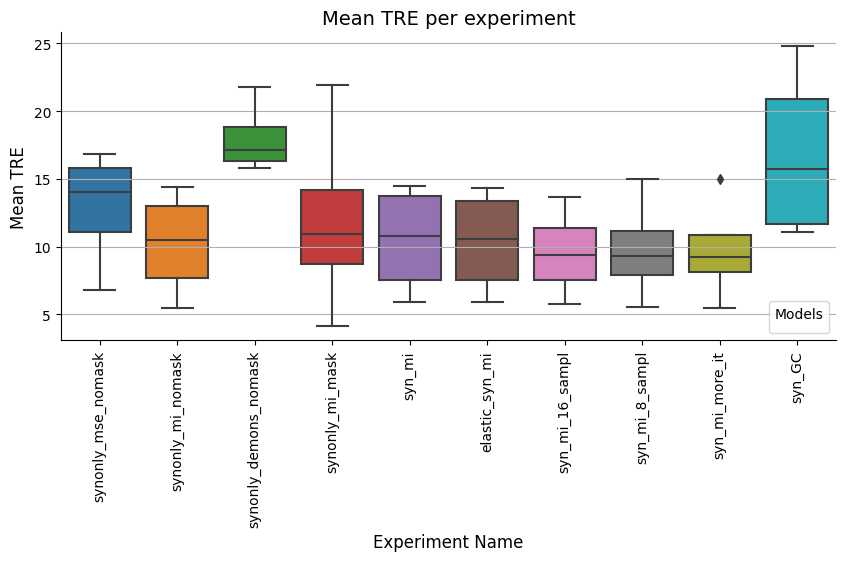

In [11]:
plt.figure(figsize=(10, 4))
plt.title('Mean TRE per experiment', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


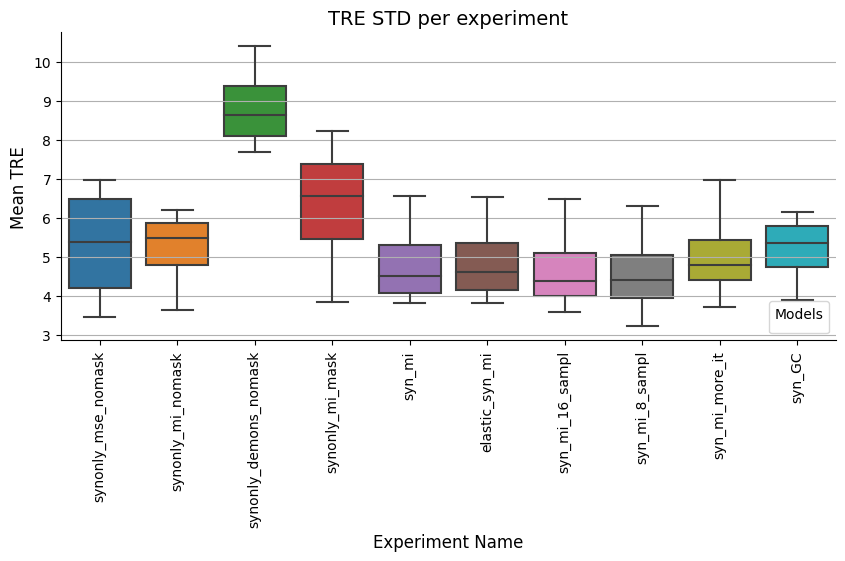

In [12]:
plt.figure(figsize=(10, 4))
plt.title('TRE STD per experiment', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="std_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)